In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# 1. DATA PREPROCESSING (ADVANCED – SCRATCH)
# =========================================================

def preprocess_data(filename, corr_threshold=0.95, z_clip=3):
    df = pd.read_csv(filename)

    countries = df['country'].values
    X = df.drop('country', axis=1)

    # -----------------------------
    # A. Handle Missing Values
    # -----------------------------
    for col in X.columns:
        mean_val = X[col].mean()
        X[col] = X[col].fillna(mean_val)

    # -----------------------------
    # B. Convert to NumPy
    # -----------------------------
    X = X.values.astype(float)

    # -----------------------------
    # C. Outlier Clipping (Z-score)
    # -----------------------------
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    z_scores = (X - mean) / std
    X = np.where(np.abs(z_scores) > z_clip, mean, X)

    # -----------------------------
    # D. Remove Low-Variance Features
    # -----------------------------
    variances = np.var(X, axis=0)
    mask = variances > 1e-4
    X = X[:, mask]

    # -----------------------------
    # E. Remove Highly Correlated Features
    # -----------------------------
    corr_matrix = np.corrcoef(X.T)
    to_remove = set()

    for i in range(len(corr_matrix)):
        for j in range(i + 1, len(corr_matrix)):
            if abs(corr_matrix[i, j]) > corr_threshold:
                to_remove.add(j)

    if to_remove:
        keep = [i for i in range(X.shape[1]) if i not in to_remove]
        X = X[:, keep]

    # -----------------------------
    # F. Standardization (Z-score)
    # -----------------------------
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_scaled = (X - mean) / std

    return X_scaled, countries


In [18]:


# =========================================================
# 2. PCA (VISUALIZATION ONLY)
# =========================================================

def pca_scratch(X, n_components=2):
    cov = np.cov(X.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    idx = np.argsort(eigvals)[::-1]
    return X @ eigvecs[:, idx[:n_components]]

# =========================================================
# 3. DISTANCE FUNCTION
# =========================================================

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# =========================================================
# 4. SILHOUETTE SCORE (SCRATCH)
# =========================================================

def silhouette_score_scratch(X, labels):
    scores = []

    for i in range(len(X)):
        same = X[labels == labels[i]]

        if len(same) <= 1:
            scores.append(0)
            continue

        a = np.mean([
            euclidean_distance(X[i], p)
            for p in same
            if not np.array_equal(p, X[i])
        ])

        b = min([
            np.mean([euclidean_distance(X[i], p) for p in X[labels == c]])
            for c in np.unique(labels)
            if c != labels[i]
        ])

        scores.append((b - a) / max(a, b))

    return np.mean(scores)


# =========================================================
# 5. K-MEANS CLUSTERING (SCRATCH)
# =========================================================

class KMeansScratch:
    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters

    def fit_predict(self, X):
        self.centroids = X[np.random.choice(len(X), self.k, replace=False)]

        for _ in range(self.max_iters):
            distances = np.array([[euclidean_distance(x, c) for c in self.centroids] for x in X])
            labels = np.argmin(distances, axis=1)

            new_centroids = np.array([
                X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i]
                for i in range(self.k)
            ])

            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        return labels

# =========================================================
# 6. HIERARCHICAL CLUSTERING (SCRATCH)
# =========================================================

class HierarchicalClusteringScratch:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters

    def fit_predict(self, X):
        clusters = {i: [i] for i in range(len(X))}

        while len(clusters) > self.n_clusters:
            centroids = {k: X[v].mean(axis=0) for k, v in clusters.items()}
            keys = list(centroids.keys())

            min_dist, pair = float('inf'), None
            for i in range(len(keys)):
                for j in range(i + 1, len(keys)):
                    d = euclidean_distance(centroids[keys[i]], centroids[keys[j]])
                    if d < min_dist:
                        min_dist, pair = d, (keys[i], keys[j])

            clusters[pair[0]].extend(clusters[pair[1]])
            del clusters[pair[1]]

        labels = np.zeros(len(X), dtype=int)
        for idx, points in enumerate(clusters.values()):
            labels[points] = idx

        return labels

# =========================================================
# 7. KNN-BASED SPECTRAL CLUSTERING (SCRATCH)
# =========================================================

class KNNSpectralClusteringScratch:
    def __init__(self, n_clusters=3, k_neighbors=10):
        self.n_clusters = n_clusters
        self.k_neighbors = k_neighbors

    def fit_predict(self, X):
        n = len(X)
        W = np.zeros((n, n))

        for i in range(n):
            dists = [(euclidean_distance(X[i], X[j]), j) for j in range(n)]
            dists.sort()
            for _, j in dists[1:self.k_neighbors + 1]:
                W[i, j] = W[j, i] = 1

        D = np.diag(W.sum(axis=1))
        L = D - W

        eigvals, eigvecs = np.linalg.eigh(L)
        embedding = eigvecs[:, :self.n_clusters]

        return KMeansScratch(self.n_clusters).fit_predict(embedding)
    


In [ ]:

# =========================================================
# 8. EXECUTION
# =========================================================

X, countries = preprocess_data(r"D:\OneDrive\Desktop\College\MrM Research\Coding\Data\data.csv")
X_pca = pca_scratch(X)

km_labels = KMeansScratch(5).fit_predict(X)
hc_labels = HierarchicalClusteringScratch(5).fit_predict(X)
knn_labels = KNNSpectralClusteringScratch(5, 15).fit_predict(X)


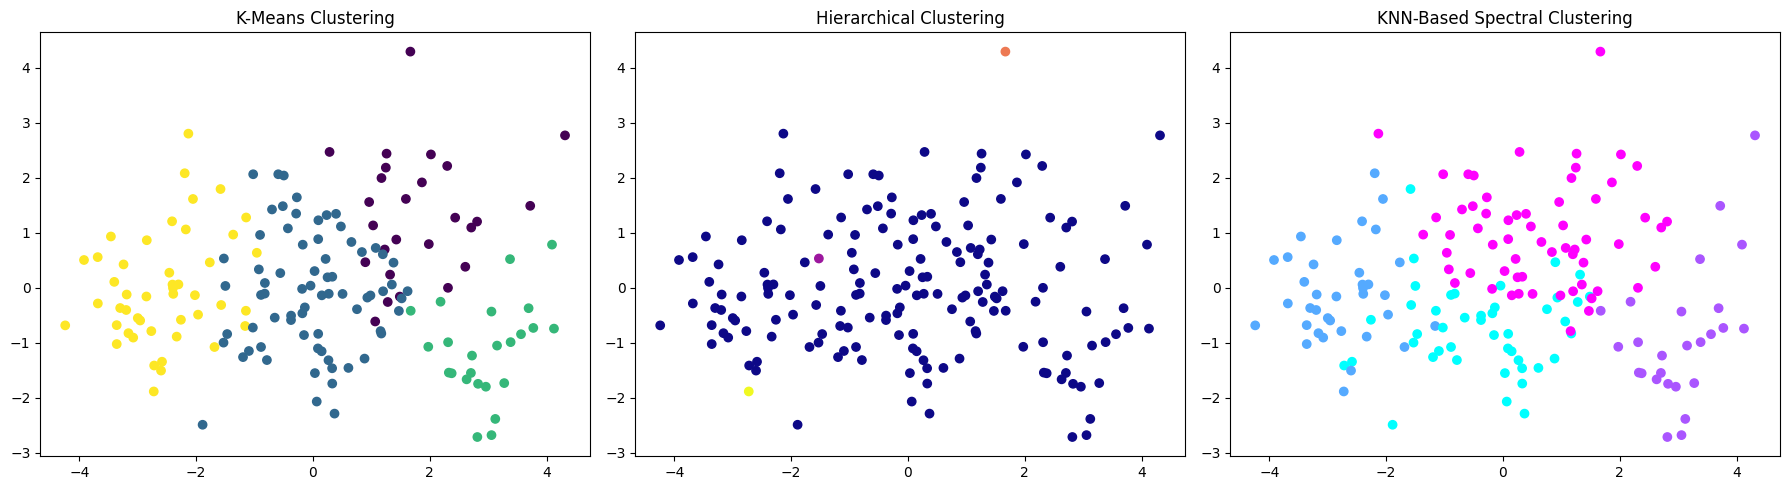


=== PERFORMANCE COMPARISON (SILHOUETTE SCORE) ===
K-Means:        0.2415
Hierarchical:   0.1016
KNN-Spectral:   0.2427


In [20]:


# =========================================================
# 9. VISUALIZATION
# =========================================================

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap='viridis')
ax[0].set_title("K-Means Clustering")

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap='plasma')
ax[1].set_title("Hierarchical Clustering")

ax[2].scatter(X_pca[:, 0], X_pca[:, 1], c=knn_labels, cmap='cool')
ax[2].set_title("KNN-Based Spectral Clustering")

plt.tight_layout()
plt.show()

# =========================================================
# 10. PERFORMANCE COMPARISON
# =========================================================

print("\n=== PERFORMANCE COMPARISON (SILHOUETTE SCORE) ===")
print(f"K-Means:        {silhouette_score_scratch(X, km_labels):.4f}")
print(f"Hierarchical:   {silhouette_score_scratch(X, hc_labels):.4f}")
print(f"KNN-Spectral:   {silhouette_score_scratch(X, knn_labels):.4f}")
